In [107]:
import joblib
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'imblearn'

In [92]:
#Load liked track ids and all liked songs features from csv
liked_track_ids = joblib.load('../Joblib_Objects/liked_track_ids')

liked_songs_df = pd.read_csv('../CSV_Data/liked_songs.csv',index_col=0)

#Load random songs csv
random_songs_df = pd.read_csv('../CSV_Data/random_songs_formatted.csv',index_col=0)

In [93]:
#Remove songs from random_songs_df if they already exist as a liked song
random_songs_df = random_songs_df.loc[~random_songs_df['track_id'].isin(liked_track_ids)]

In [94]:
#Format dataframe for model creation

#If song is a liked song, this will define a favourite song (1 for favourite, 0 for non-favourite)
liked_songs_df['favourite'] = 1
random_songs_df['favourite'] = 0

#Format genres to only have 1 listed
liked_songs_df['genre'] = liked_songs_df['genre'].map(lambda x: x.split('[')[1].split(']')[0].split(', ')[0].strip("'"))
liked_songs_df['genre'] = liked_songs_df['genre'].map(lambda x: 'Not Available' if x == '' else x)

In [95]:
#Drop track id and artist
liked_songs_df = liked_songs_df.drop(columns=['track_id','artist'])
random_songs_df = random_songs_df.drop(columns=['track_id'])

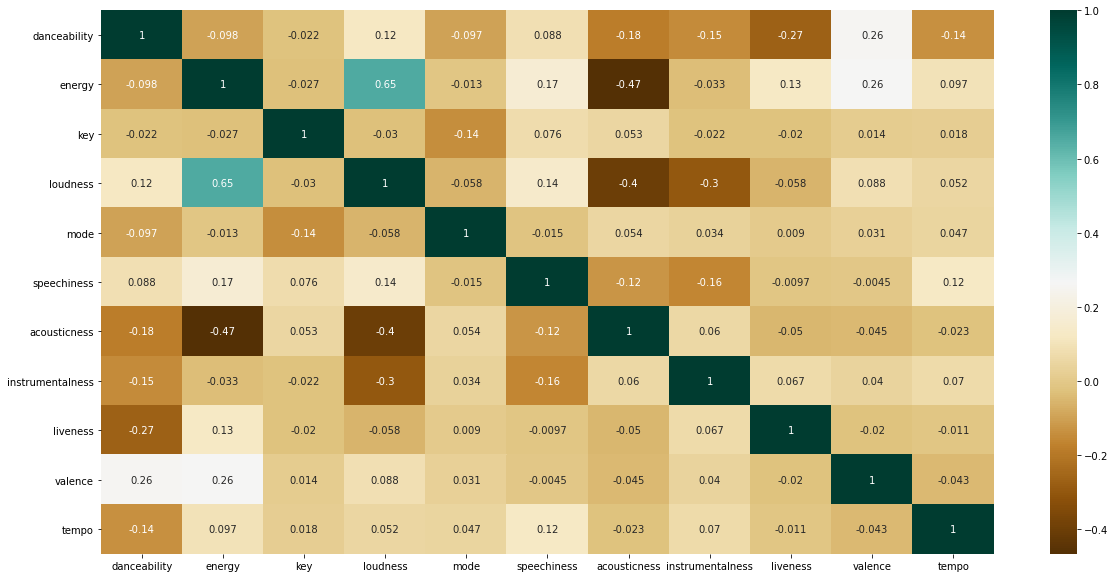

In [96]:
#Show Correlation Matrix of combined dataframe
liked_songs_df_matrix = liked_songs_df.drop(columns='favourite')

plt.figure(figsize=(20,10))
c_liked = liked_songs_df_matrix.corr()
corr_liked = sns.heatmap(c_liked,cmap="BrBG",annot=True)

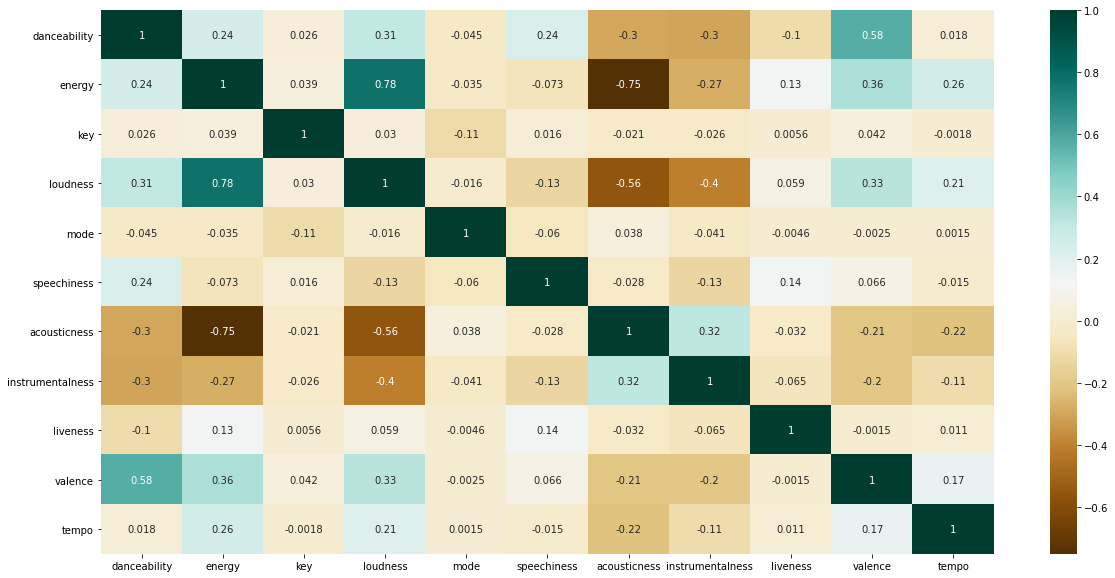

In [97]:
#Show Correlation Matrix of combined dataframe
random_songs_df_matrix = random_songs_df.drop(columns='favourite')

plt.figure(figsize=(20,10))
c_random = random_songs_df_matrix.corr()
corr_random = sns.heatmap(c_random,cmap="BrBG",annot=True)

In [98]:
#Combine liked songs and random songs data into one dataframe
combined_songs_df = pd.concat([liked_songs_df,random_songs_df])
combined_songs_df = combined_songs_df.reset_index(drop=True)

In [100]:
#Label encode genres
from sklearn.preprocessing import LabelEncoder

genres_label_encoder = LabelEncoder()
genres = combined_songs_df['genre'].to_list()
genres_label_encoder.fit(genres)

combined_songs_df['genre'] = combined_songs_df['genre'].map(lambda x: genres_label_encoder.transform([x])[0])

#Dump LabelEncoder using joblib to be used when using model to determine if song is favourite
joblib.dump(genres_label_encoder,'../Joblib_Objects/genres_label_encoder')

['../Joblib_Objects/genres_label_encoder']

In [101]:
#Separate combined dataframe into X (features) and y (category)
y = combined_songs_df['favourite']
X = combined_songs_df.drop(columns='favourite')

#Scale values to remove bias in values
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#Dump scaler using joblib
joblib.dump(scaler,'../Joblib_Objects/scaler')

['../Joblib_Objects/scaler']

In [103]:
#Check ratio of favourites to non-favourites
combined_songs_df['favourite'].value_counts()

0    17503
1      983
Name: favourite, dtype: int64

In [13]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import f1_score
from scipy.stats import uniform, randint

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
import xgboost

In [14]:
# Train / Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .20)

In [15]:
# Logistic Regression
lr = LogisticRegression()
lr_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring="f1")
np.mean(lr_scores)

0.060485144485144485

In [16]:
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    'max_depth':[15,20,30],
}
dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5))])
dtc.fit(X_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 30}

In [18]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=30)
dt_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

0.34568698564625705

In [19]:
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[6,12,15,20],
    'n_estimators':[20,30]
}
clf = Pipeline([('CV',GridSearchCV(RandomForestClassifier(), parameters, cv = 5))])
clf.fit(X_train, y_train)
clf.named_steps['CV'].best_params_

{'max_depth': 6, 'n_estimators': 30}

In [20]:
# Cross-validation for RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 20, max_depth = 30))])
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

0.17848003083297198